In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential, optimizers
from tensorflow.keras.layers import Embedding
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Bidirectional

In [ ]:
Quor = pd.read_csv("/kaggle/input/quora-question-pairs/train.csv.zip")
Quor.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
# Check for missing values
missing_values = Quor.isnull().sum()
# Handle missing values
Quor = Quor.dropna()

In [ ]:
columns_to_drop = ['id', 'qid1', 'qid2']
Quor = Quor.drop(columns=columns_to_drop, axis=1)
Quor.head()

,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
from sklearn.model_selection import train_test_split

X = Quor.drop(columns=['is_duplicate'])
y = Quor['is_duplicate']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Remove the punctuation from the questions and apply some filters to the data
import string
import re
from multiprocessing import Pool, cpu_count

def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def convert_to_lower(text):
    return text.lower()

def remove_contractions(text):
    # Define a list of common contractions and their expanded forms
    contractions = {
        "don't": "do not",
        "won't": "will not",
        "can't": "cannot",
        # Add more contractions and their expansions as needed
    }
    for contraction, expansion in contractions.items():
        text = text.replace(contraction, expansion)
    return text

def replace_currency_symbols(text):
    # Define a dictionary mapping currency symbols to currency names
    currency_symbols = {
        "$": "USD",
        "€": "EUR",
        "£": "GBP",

    }
    for symbol, currency_name in currency_symbols.items():
        text = text.replace(symbol, currency_name)
    return text

def remove_hyperlinks(text):
    # Remove URLs and hyperlinks using regular expression
    text = re.sub(r'http\S+', '', text)
    return text

def remove_html_tags(text):
    # Remove HTML tags using regular expression
    text = re.sub(r'<.*?>', '', text)
    return text

def process_column(column):
    with Pool(cpu_count()) as pool:
        processed_column = pool.map(remove_punctuation, column)
        processed_column = pool.map(convert_to_lower, processed_column)
        processed_column = pool.map(remove_contractions, processed_column)
        processed_column = pool.map(replace_currency_symbols, processed_column)
        processed_column = pool.map(remove_hyperlinks, processed_column)
        processed_column = pool.map(remove_html_tags, processed_column)
    return processed_column

In [ ]:
X_train['question1'] = process_column(X_train['question1'])
X_train['question2'] = process_column(X_train['question2'])

In [ ]:
X_train.head()

,question1,question2
174950,india what are job options and future options ...,jobs and careers in india i am currently in my...
119443,which is worlds best romantic movie,what is the best romantic movie of all time
252943,which is best place to live in hyderabad,which is best place to live hyderabad or mumbai
13551,what should i do to be an athlete in a month,what is shop act licence
274898,how do you learn to code on wordpress,in how much time can i learn to code a wordpre...


# Tokenization and Embedding

In [ ]:
def load_glove_embeddings(file_path):
    embeddings_index = {}
    f = open(file_path)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Found %s word vectors.' % len(embeddings_index))
    return embeddings_index

glove_file = '/kaggle/input/glove-6b/glove.6B.100d.txt'
glove_embeddings = load_glove_embeddings(glove_file)

Found 400000 word vectors.


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
texts = X_train['question1'].values + X_train['question2'].values
tokenizer.fit_on_texts(texts)
seq_q1 = tokenizer.texts_to_sequences(X_train['question1'].values)
seq_q2 = tokenizer.texts_to_sequences(X_train['question2'].values)
vocab = tokenizer.word_index

In [ ]:
max_size_col1 = max(len(lst) for lst in seq_q1)
max_size_col2 = max(len(lst) for lst in seq_q2)
max_seq_length = max(max_size_col1, max_size_col2)
max_seq_length

237

In [ ]:
seq_q1 = pad_sequences(seq_q1, maxlen = max_seq_length)
seq_q2 = pad_sequences(seq_q2, maxlen = max_seq_length)

In [ ]:
seq_q1[0].shape

(237,)

In [ ]:
number_of_words = len(vocab)
number_of_words

180505

In [ ]:
def create_embedding_matrix(word_index, embeddings_index, embedding_dim):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

embedding_dim = 100
embedding_matrix = create_embedding_matrix(vocab, glove_embeddings, embedding_dim)
embedding_matrix.shape

(180506, 100)

In [ ]:
embedding_matrix[1]

array([-0.038194  , -0.24487001,  0.72812003, -0.39961001,  0.083172  ,
        0.043953  , -0.39140999,  0.3344    , -0.57545   ,  0.087459  ,
        0.28786999, -0.06731   ,  0.30906001, -0.26383999, -0.13231   ,
       -0.20757   ,  0.33395001, -0.33848   , -0.31742999, -0.48335999,
        0.1464    , -0.37303999,  0.34577   ,  0.052041  ,  0.44946   ,
       -0.46970999,  0.02628   , -0.54154998, -0.15518001, -0.14106999,
       -0.039722  ,  0.28277001,  0.14393   ,  0.23464   , -0.31020999,
        0.086173  ,  0.20397   ,  0.52623999,  0.17163999, -0.082378  ,
       -0.71787   , -0.41531   ,  0.20334999, -0.12763   ,  0.41367   ,
        0.55186999,  0.57907999, -0.33476999, -0.36559001, -0.54856998,
       -0.062892  ,  0.26583999,  0.30204999,  0.99774998, -0.80480999,
       -3.0243001 ,  0.01254   , -0.36941999,  2.21670008,  0.72201002,
       -0.24978   ,  0.92136002,  0.034514  ,  0.46744999,  1.10790002,
       -0.19358   , -0.074575  ,  0.23353   , -0.052062  , -0.22

# Model

In [ ]:
embedding_dim = 100
number_of_words+=1

In [ ]:
def siamese_lstm_network(max_seq_length, number_of_words, embedding_dim, embedding_matrix):

    inputA = layers.Input(shape=max_seq_length, name='input_A')
    inputB = layers.Input(shape=max_seq_length, name='input_B')

    embedding_layer = Embedding(
                    number_of_words,
                    embedding_dim,
                    input_length= max_seq_length,
                    weights=[embedding_matrix],
                    trainable=False
                )
    embedded_sequences_q1 = embedding_layer(inputA)
    embedded_sequences_q2 = embedding_layer(inputB)
    lstm_layer1 = Bidirectional(layers.LSTM(64, return_sequences=True))
    lstm_output_A1 = lstm_layer1(embedded_sequences_q1)
    lstm_output_B1 = lstm_layer1(embedded_sequences_q2)

    lstm_layer2 = Bidirectional(layers.LSTM(64, return_sequences=True))
    lstm_output_A2 = lstm_layer2(lstm_output_A1)
    lstm_output_B2 = lstm_layer2(lstm_output_B1)


    merged_features = layers.Concatenate()([lstm_output_A2, lstm_output_B2])
    lstm_pooled = layers.GlobalAveragePooling1D()(merged_features)
    dense_layer = layers.Dense(512, activation='relu')(lstm_pooled)
    output_layer = layers.Dense(1, activation='sigmoid')(dense_layer)

    model = Model(inputs=[inputA, inputB], outputs=output_layer)

    return model


# Create the Siamese LSTM network model
model = siamese_lstm_network(max_seq_length, number_of_words, embedding_dim, embedding_matrix)
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [ ]:
val_seq_q1 = tokenizer.texts_to_sequences(X_val['question1'].values)
val_seq_q2 = tokenizer.texts_to_sequences(X_val['question2'].values)
val_seq_q1 = pad_sequences(val_seq_q1, maxlen = max_seq_length)
val_seq_q2 = pad_sequences(val_seq_q2, maxlen = max_seq_length)

In [ ]:
# Fit the model
batch_size = 512
epochs = 20

history = model.fit(
    x=[seq_q1, seq_q2],  # Pairs of input sequences
    y= y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([val_seq_q1, val_seq_q2], y_val)  # Validation data
)

Epoch 1/20

632/632 [==============================] - 158s 224ms/step - loss: 0.5551 - accuracy: 0.7080 - val_loss: 0.5167 - val_accuracy: 0.7370

Epoch 2/20

632/632 [==============================] - 139s 219ms/step - loss: 0.4893 - accuracy: 0.7555 - val_loss: 0.4716 - val_accuracy: 0.7666

Epoch 3/20

632/632 [==============================] - 129s 204ms/step - loss: 0.4551 - accuracy: 0.7770 - val_loss: 0.4483 - val_accuracy: 0.7810

Epoch 4/20

632/632 [==============================] - 139s 220ms/step - loss: 0.4305 - accuracy: 0.7930 - val_loss: 0.4405 - val_accuracy: 0.7871

Epoch 5/20

632/632 [==============================] - 139s 219ms/step - loss: 0.4119 - accuracy: 0.8037 - val_loss: 0.4290 - val_accuracy: 0.7965

Epoch 6/20

632/632 [==============================] - 139s 219ms/step - loss: 0.3971 - accuracy: 0.8122 - val_loss: 0.4232 - val_accuracy: 0.8004

Epoch 7/20

632/632 [==============================] - 129s 204ms/step - loss: 0.3818 - accuracy: 0.8217 - val_l

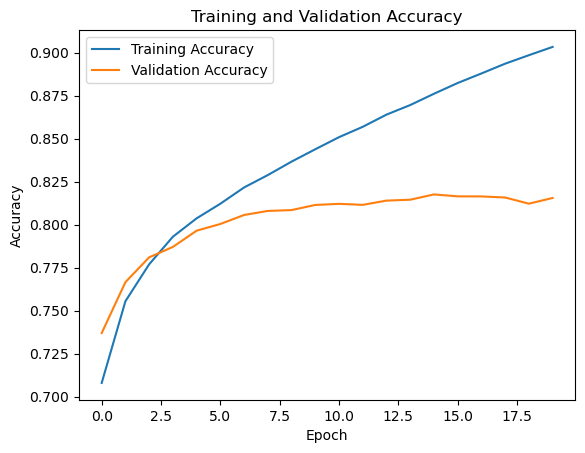

In [ ]:
# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

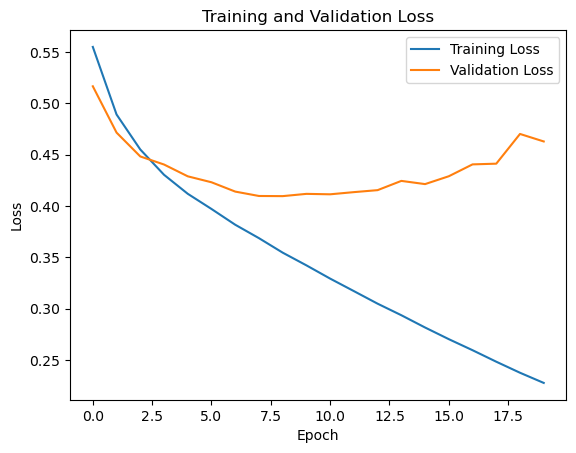

In [ ]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Model evaluation

2527/2527 [==============================] - 82s 32ms/step


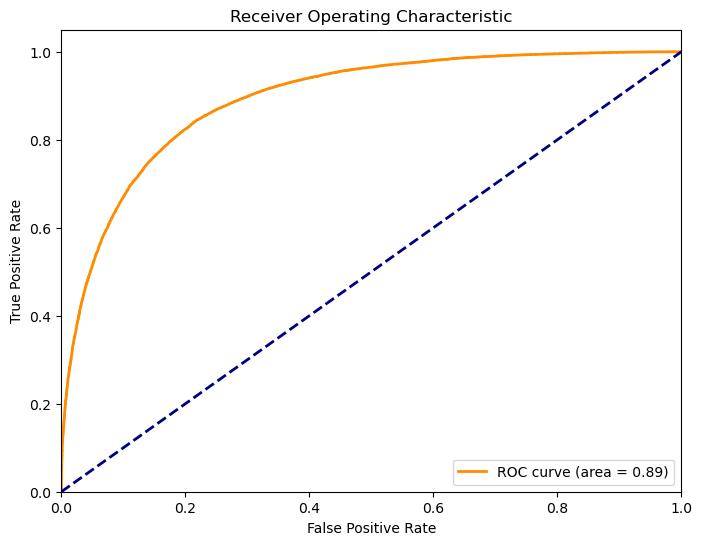

Accuracy: 0.815540824655569

Precision: 0.7351281485451279

Recall: 0.7816773934030571

F1-score: 0.7576884960927981

ROC-AUC: 0.8924840083839495

Confusion Matrix:

[[42624  8402]

 [ 6513 23319]]


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc

# Make predictions on validation data
y_pred_probs = model.predict([val_seq_q1, val_seq_q2])

# Choose a threshold for converting probabilities to binary predictions
threshold = 0.5

y_pred = (y_pred_probs > threshold).astype(int)


# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_probs)

# Create a confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Print evaluation metrics and confusion matrix
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("ROC-AUC:", roc_auc)
print("Confusion Matrix:")
print(cm)

In [ ]:
# Flatten y_pred if it's not already flattened
y_pred = y_pred.flatten()
predictions_df = pd.DataFrame({'Predicted': y_pred, 'GroundTruth': y_val})
# Filter for incorrect predictions
incorrect_predictions = (y_pred != y_val)
incorrect_data = X_val[incorrect_predictions]

# Concatenate the incorrect_data DataFrame with predictions_df
incorrect_data_with_predictions = pd.concat([incorrect_data.reset_index(drop=True), predictions_df[incorrect_predictions].reset_index(drop=True)], axis=1)

# Display the result
pd.set_option('display.max_colwidth', 1000)
incorrect_data_with_predictions


,question1,question2,Predicted,GroundTruth
0,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,1,0
1,Is odd even scheme bad for Delhi?,Is ODD-EVEN scheme good for Delhi?,1,0
2,"How much will I grow taller and why? I am 16 years old male, My height is 5' 3 inches, My dad's height is 5'10 and mom's height is 5' 2 inches ?","I am 27 year old male and my height is 5.3 inch and weight is 46 kg, How can I gain weight?",1,0
3,How do I find Pokémon in Pokémon GO?,How do I find Pokémon Eggs in Pokémon GO?,1,0
4,How do you cut your own hair?,Are you cheap if you cut your own hair?,1,0
...,...,...,...,...
14910,Is Area 51 real?,"Area 51 is a real place, but what and where are numbers 1 to 50 and what do they do?",0,1
14911,What is the best way to prepare for BSNL TTA(JE) along with my full time job?,What is the best way to prepare for BSNL JE(TTA) along with my job?,1,0
14912,What should a person new to meditation concentrate on while meditating?,How can I stop becoming bored while meditating?,1,0
14913,How would you start a business as a 15 years old?,How do you start a successful business as a 15-year-old?,0,1


# Test with customized input

In [ ]:
raw_question1 = "How do I bake a chocolate cake?"
raw_question2 = "What are the steps to make a chocolate cake?"

# Convert to sequences
seq_raw_question1 = tokenizer.texts_to_sequences([raw_question1])
seq_raw_question2 = tokenizer.texts_to_sequences([raw_question2])

# Pad sequences
padded_question1 = pad_sequences(seq_raw_question1, maxlen=max_seq_length)
padded_question2 = pad_sequences(seq_raw_question2, maxlen=max_seq_length)

# Predict using the trained model
raw_predictions = model.predict([padded_question1, padded_question2])

# Choose a threshold for converting probabilities to binary predictions
threshold = 0.5
raw_prediction = (raw_predictions > threshold).astype(int)[0][0]

if raw_prediction == 1:
    print("The input question pair is duplicate.")
else:
    print("The input question pair is not duplicate.")


1/1 [==============================] - 0s 51ms/step

The input question pair is duplicate.
